# テーマ：Fashion-MNISTデータセットを畳み込みニューラルネットワーク（CNN）で学習する

## 今回参考にしたもの
* [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
* [Deep Learning with TensorFlow 2.X (& Keras)](https://github.com/yusugomori/deeplearning-tf2)

## 0. Install TensorFlow 2.0

## 1. Prepare dataset

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

#print(tfds.list_builders())
dataset, info = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
dataset_test, dataset_train = dataset['test'], dataset['train']
print(info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteJ7CKIV/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteJ7CKIV/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir=PosixGPath('/tmp/tmpeg54gpbttfds'),
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitIn

In [2]:
def convert_types(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 128

dataset_train = dataset_train.map(convert_types).shuffle(10000).batch(batch_size)
dataset_test = dataset_test.map(convert_types).batch(batch_size)

## 2. Data Augmentation

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#datagen = ImageDataGenerator()
datagen = ImageDataGenerator(rotation_range = 10, horizontal_flip = True, zoom_range = 0.1)

## 3. Define model

In [5]:
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from tensorflow.keras import Model

class ResidualBlock(Model):
    def __init__(self, channel_in = 64, channel_out = 256):
        super().__init__()

        channel = channel_out // 4

        self.conv1 = Conv2D(channel, kernel_size = (1, 1), padding = "same")
        self.bn1 = BatchNormalization()
        self.av1 = Activation(tf.nn.relu)
        self.conv2 = Conv2D(channel, kernel_size = (3, 3), padding = "same")
        self.bn2 = BatchNormalization()
        self.av2 = Activation(tf.nn.relu)
        self.conv3 = Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
        self.bn3 = BatchNormalization()
        self.shortcut = self._shortcut(channel_in, channel_out)
        self.add = Add()
        self.av3 = Activation(tf.nn.relu)

    def call(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.av1(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.av2(h)
        h = self.conv3(h)
        h = self.bn3(h)
        shortcut = self.shortcut(x)
        h = self.add([h, shortcut])
        y = self.av3(h)
        return y

    def _shortcut(self, channel_in, channel_out):
        if channel_in == channel_out:
            return lambda x : x
        else:
            return self._projection(channel_out)

    def _projection(self, channel_out):
        return Conv2D(channel_out, kernel_size = (1, 1), padding = "same")

class ResNet50(Model):
    def __init__(self, input_shape, output_dim=10):
        super().__init__()

        self._layers = [
            # conv1
            Conv2D(64, input_shape = input_shape, kernel_size = (7, 7), strides=(2, 2), padding = "same"),
            BatchNormalization(),
            Activation(tf.nn.relu),
            # conv2_x
            MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same"),
            ResidualBlock(64, 256),
            [
                ResidualBlock(256, 256) for _ in range(2)
            ],
            # conv3_x
            Conv2D(512, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(512, 512) for _ in range(4)
            ],
            # conv4_x
            Conv2D(1024, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(1024, 1024) for _ in range(6)
            ],
            # conv5_x
            Conv2D(2048, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(2048, 2048) for _ in range(3)
            ],
            # last part
            GlobalAveragePooling2D(),
            Dense(1000, activation=tf.nn.relu),
            Dense(output_dim, activation=tf.nn.softmax),
            Dense(output_dim, activation = tf.nn.softmax)
        ]

    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    x = l(x)
            else:
                x = layer(x)
        return x


model = ResNet50(input_shape=(28, 28, 1), output_dim=10)
model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "res_net50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 residual_block (ResidualBl  multiple                  75904     
 ock)                                                            
                                                         

In [6]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9, decay =  0.0001)

## 4. Prepare training

In [7]:
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')

In [8]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = model(image)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, predictions)

@tf.function
def test_step(image, label):
    predictions = model(image)
    loss = loss_object(label, predictions)

    test_loss(loss)
    test_accuracy(label, predictions)

In [9]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3414846753750748816
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14410383360
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15074917190871445033
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

## 5. Train

In [10]:
import time

num_epoch = 10
start_time = time.time()

train_accuracies = []
test_accuracies = []

for epoch in range(num_epoch):
    for image, label in dataset_train:
        for _image, _label in datagen.flow(image, label, batch_size = batch_size):
            train_step(_image, _label)
            break

    for test_image, test_label in dataset_test:
        test_step(test_image, test_label)

    train_accuracies.append(train_accuracy.result())
    test_accuracies.append(test_accuracy.result())

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, spent_time: {} min'
    spent_time = time.time() - start_time
    print(template.format(epoch + 1, train_loss.result(), train_accuracy.result() * 100, test_loss.result(), test_accuracy.result() * 100, spent_time / 60))

Epoch 1, Loss: 2.3014492988586426, Accuracy: 10.753334045410156, Test Loss: 2.3029627799987793, Test Accuracy: 10.0, spent_time: 1.434139076868693 min
Epoch 2, Loss: 2.3021442890167236, Accuracy: 10.271666526794434, Test Loss: 2.3027968406677246, Test Accuracy: 10.0, spent_time: 2.0607635339101154 min
Epoch 3, Loss: 2.302354335784912, Accuracy: 10.18166732788086, Test Loss: 2.302751302719116, Test Accuracy: 10.0, spent_time: 2.646216050783793 min
Epoch 4, Loss: 2.302462100982666, Accuracy: 10.071249961853027, Test Loss: 2.302725315093994, Test Accuracy: 10.0, spent_time: 3.249920201301575 min
Epoch 5, Loss: 2.3025288581848145, Accuracy: 10.041000366210938, Test Loss: 2.302711009979248, Test Accuracy: 10.0, spent_time: 3.8731273770332337 min
Epoch 6, Loss: 2.302574396133423, Accuracy: 9.989167213439941, Test Loss: 2.30269455909729, Test Accuracy: 10.0, spent_time: 4.455133513609568 min
Epoch 7, Loss: 2.3026037216186523, Accuracy: 9.978809356689453, Test Loss: 2.3026914596557617, Test Ac

## 6. Show transition of accuracy

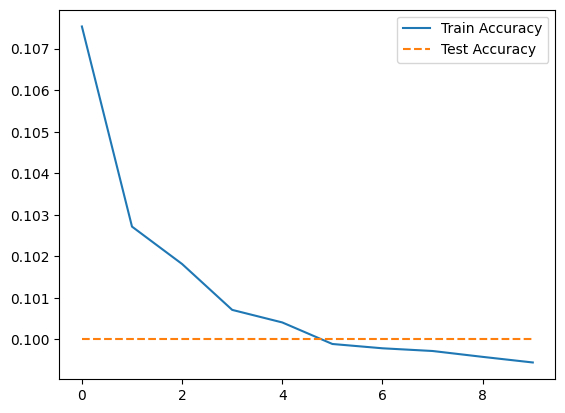

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label = 'Train Accuracy')
plt.plot(test_accuracies, linestyle = 'dashed', label = 'Test Accuracy')
plt.legend()
plt.show()

### Model Performance Comparison: AlexNet vs. ResNet50 (10 Epochs)

#### AlexNet Results:
- Final training accuracy: Approximately 91.9%
- Final test accuracy: Approximately 91.4%
- Observations: The model shows a consistent increase in accuracy over epochs, indicating steady learning. The small gap between training and test accuracy suggests that the model generalizes well.

#### ResNet50 Results:
- Final training accuracy: 100%
- Final test accuracy: Approximately 89.0%
- Observations: ResNet50 achieves perfect training accuracy, which might indicate overfitting, as the test accuracy is significantly lower. Despite its deeper architecture, it does not outperform AlexNet on the test set.

### Interpretation:
- **Generalization**: AlexNet seems to generalize better to unseen data in this scenario, as indicated by the closer performance metrics between training and testing.
- **Overfitting**: ResNet50, while achieving higher training accuracy, appears to overfit the training data, leading to lower test accuracy compared to AlexNet.
- **Complexity vs. Dataset Simplicity**: The superior performance of AlexNet may suggest that for a relatively simple dataset like Fashion MNIST, a less complex model can be more appropriate and efficient.
- **Training Dynamics**: The training process of ResNet50 shows a rapid climb to high training accuracy, which is not matched by its test accuracy, hinting that the model may benefit from techniques to mitigate overfitting, such as regularization or more extensive data augmentation.

In conclusion, while ResNet50 is a more complex model with a capacity for higher learning, AlexNet provides a better balance between training and test performance for the Fashion MNIST dataset within the 10 epochs of training.